Try the equations in primitive form. Primitive variables $(\Phi, v_j)$. From there $W^{-2} = 1 - v^2$ and assuming Minkowski on the transverse directions we have $v_j = v^j = v$. The conserved variables are then $D = \Phi W$ and $S = S_j = \Phi W^2 v_j = \Phi W^2 v$.

In [1]:
import sympy
sympy.init_printing()

In [2]:
phi = sympy.symbols('Phi', positive=True)
v = sympy.symbols('v')
W = 1 / sympy.sqrt(1 - v**2)
D = phi * W
S = phi * W**2 * v
fD = D * v
fS = S * v + phi**2 / 2

In [3]:
q = sympy.Matrix([D, S])
w = [phi, v]
dqdw = q.jacobian(w)
flux = sympy.Matrix([fD, fS])
dfdw = flux.jacobian(w)
J = dqdw.inv()*dfdw

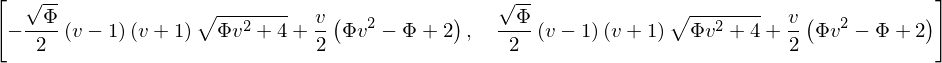

In [4]:
evals = list(J.eigenvals().keys())
evals

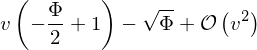

In [5]:
evals[1].series(v, 0, 2)

So for small $v$ *and* for small $\Phi$ we get $v \pm \sqrt{\Phi}$ as expected for the Newtonian limit. How about for small $\Phi$ alone?

In [6]:
evals[1].series(phi, 0, 1)

So it's limited by the Lorentz factor, essentially.

If we set $v$ to zero then we'll get the "acoustic speed":

In [7]:
evals[0].subs(v, 0).simplify()

So it is precisely the Newtonian limit version. The relativistic "addition formula" here isn't obvious. However, we can say that for very small height we get the advective velocity, for very small velocity we get the Newtonian acoustic speed, but it gets more complicated after that.

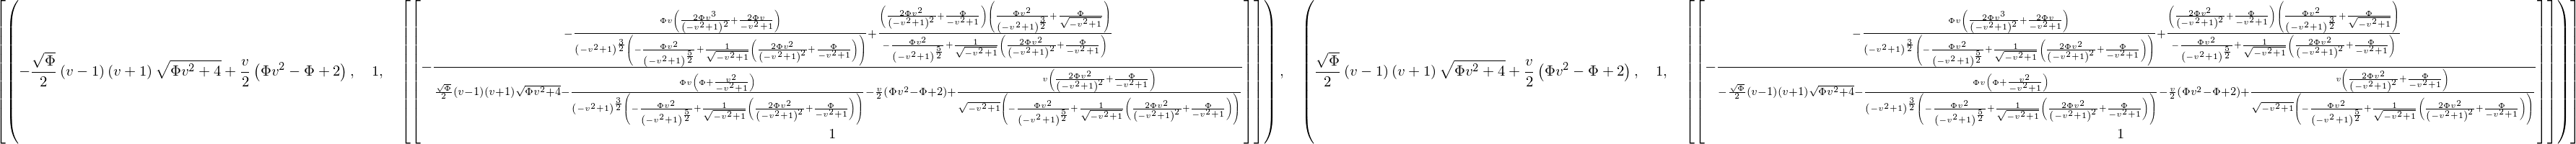

In [8]:
evecs = J.eigenvects()
evecs

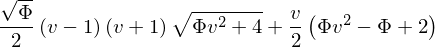

In [9]:
l1=evecs[1][0].simplify()
l1

Check that this is the left eigenvalue:

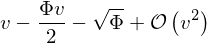

In [10]:
l1.series(v, 0, 2).series(phi, 0, 1)

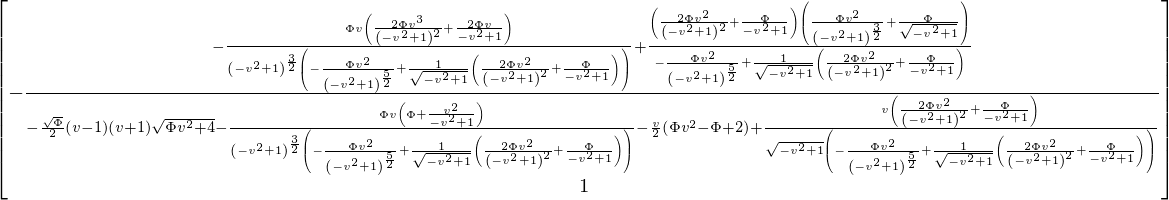

In [11]:
r1=sympy.Matrix(evecs[1][2][0])
r1

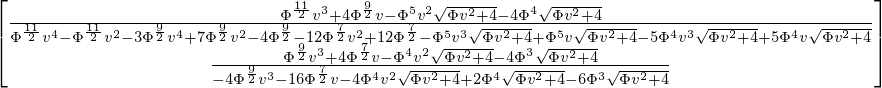

In [12]:
divisor = sympy.Matrix([l1]).jacobian(w).dot(r1)
rhs=r1/divisor.simplify()
rhs2=rhs.copy()
rhs2[0] = rhs[0].simplify()
rhs2[1] - rhs[1].simplify()
rhs2

Again, check the limit:

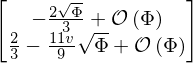

In [13]:
limit_rhs = rhs2.copy()
for i in range(2):
    limit_rhs[i] = rhs2[i].series(v, 0, 2).removeO().series(phi, 0, 1)
limit_rhs

Again, for small enough $\Phi$ this matches the expected $ 2/3 (-\sqrt{\Phi}, 1)^T$.

What are the chances of a closed form solution?

In [14]:
fphi = sympy.Function('Phi')
fv = sympy.Function('v')
xi = sympy.symbols('xi')
eq1 = sympy.Eq(sympy.Derivative(fphi(xi), xi), rhs2[0].subs(phi, fphi(xi)).subs(v, fv(xi)))
eq2 = sympy.Eq(sympy.Derivative(fv(xi), xi), rhs2[1].subs(phi, fphi(xi)).subs(v, fv(xi)))


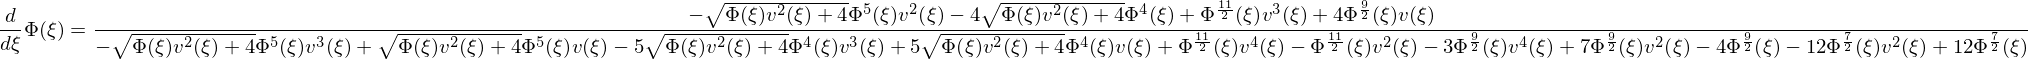

In [15]:
eq1

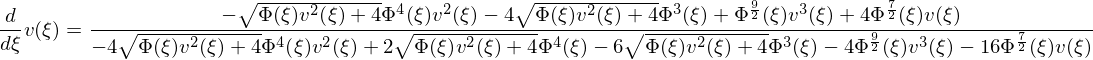

In [16]:
eq2

In [17]:
#sympy.dsolve((eq1, eq2))
# Doesn't work.

# Brute force numerics

In [18]:
eval_sp = sympy.lambdify((phi, v), l1, modules='numpy')
def eval_m(w):
    phi, v = w
    return eval_sp(phi, v)

In [19]:
import numpy
w = numpy.array([0.8, 0])
eval_m(w)

In [20]:
rhs_sp = sympy.lambdify((phi, v), rhs2, modules='numpy')
def rhs_m(w, xi):
    phi, v = w
    return numpy.array(rhs_sp(phi, v).flatten())

In [21]:
rhs_m(w, eval_m(w))

array([-0.81311563,  0.90909091])

In [22]:
from scipy.integrate import odeint
from scipy.optimize import brentq, newton, root

In [23]:
lam_vals = numpy.linspace(eval_m(w), 0)
w_all = odeint(rhs_m, w, lam_vals)

In [24]:
%matplotlib inline
from matplotlib import pyplot

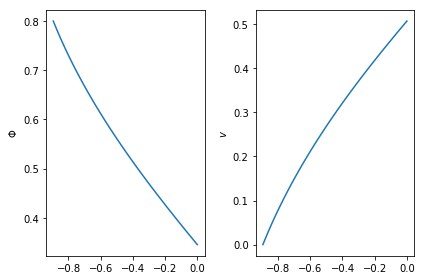

In [25]:
fig, ax = pyplot.subplots(1, 2)
ax[0].plot(lam_vals, w_all[:, 0])
ax[0].set_ylabel(r"$\Phi$")
ax[1].plot(lam_vals, w_all[:, 1])
ax[1].set_ylabel(r"$v$")
fig.tight_layout()

In [26]:
def shock_residual(guess, phi_star, w):
    v_star, Vs = guess
    phi, v = w
    W = 1 / numpy.sqrt(1 - v**2)
    W_star = 1 / numpy.sqrt(1 - v_star**2)
    q = numpy.array([phi * W, phi * W**2 * v])
    q_star = numpy.array([phi_star * W_star, phi_star * W_star**2 * v_star])
    #f = q * v + numpy.array([0, phi**2 / 2])
    #f_star = q_star * v_star + numpy.array([0, phi_star**2 / 2])
    f = numpy.array([phi * W * v, phi * W**2 * v**2 + (phi**2) / 2])
    f_star = numpy.array([phi_star * W_star * v_star, phi_star * W_star**2 * v_star**2 + (phi_star**2) / 2])
    residual = Vs * (q - q_star) - (f - f_star)
    #print('shock', guess, residual)
    return residual

In [27]:
def lamstar_residual(lam_star, phi_star, w):
    """
    Find the eval in the star state that gives desired phi
    """
    lam_left=eval_m(w)
    lam_vals=[lam_left, lam_star]
    w_all = odeint(rhs_m, w, lam_vals)
    return phi_star - w_all[-1, 0]

def phi_residual(phi_star, wl, wr):
    lam_l = eval_m(wl)
    lam_r = eval_m(wr)
    lam_star = newton(lamstar_residual, 0.25, args=(phi_star, wl))
    #print('lam_star', lam_star)
    lam_vals=[lam_l, lam_star]
    w_raref = odeint(rhs_m, wl, lam_vals)[-1, :]
    
    guess = numpy.array([w_raref[1], 0.7])
    result = root(shock_residual, guess, args=(phi_star, wr))
    #print('result', result.x)
    w_shock = numpy.array([phi_star, result.x[0]])
    
    return w_raref[1] - w_shock[1]

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


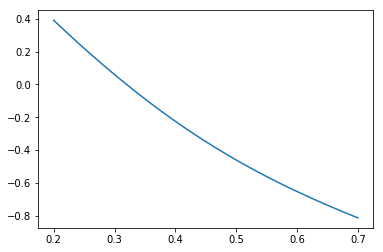

In [28]:
wl = numpy.array([0.80, 0])
wr = numpy.array([0.10, 0])
phis = numpy.linspace(0.2, 0.7)
ress = numpy.zeros_like(phis)
for i, phi_s_g in enumerate(phis):
    ress[i] = phi_residual(phi_s_g, wl, wr)
pyplot.plot(phis, ress)

In [29]:
phi_star = brentq(phi_residual, 0.3, 0.4, args=(wl, wr))
phi_star

In [30]:
def dam_break(wl, wr, xi_min=-1, xi_max=1):
    assert wl[0] > wr[0]
    # This will probably only work for a very limited range as I've hard-coded limits
    phi_star = brentq(phi_residual, 1.1*wr[0], 0.9*wl[0], args=(wl, wr))
#    phi_star = brentq(phi_residual, 0.3, 0.4, args=(wl, wr))
    # Left state
    lams = [xi_min]
    phis = [wl[0]]
    vs = [wl[1]]
    # Find rarefaction tail
    lam_l = eval_m(wl)
    lams.append(lam_l)
    phis.append(wl[0])
    vs.append(wl[1])
    # Solve down rarefaction
    lam_star = newton(lamstar_residual, 0.25, args=(phi_star, wl))
    lams_raref = numpy.linspace(lam_l, lam_star)
    w_raref = odeint(rhs_m, wl, lams_raref)
    for i, l in enumerate(lams_raref):
        lams.append(l)
        phis.append(w_raref[i, 0])
        vs.append(w_raref[i, 1])
    # Find shock result
    guess = numpy.array([w_raref[-1, 1], 0.9])
    result = root(shock_residual, guess, args=(phi_star, wr))
    v_star, Vs = result.x
    #print('Vs', Vs, 'v_star_resid', v_star - w_raref[-1, 1])
    lams.append(Vs)
    phis.append(phi_star)
    vs.append(v_star)
    lams.append(Vs)
    phis.append(wr[0])
    vs.append(wr[1])
    #    Right state
    lams.append(xi_max)
    phis.append(wr[0])
    vs.append(wr[1])
    
    return lams, phis, vs

In [31]:
wl = numpy.array([0.80, 0])
wr = numpy.array([0.10, 0])
lams, phis, vs = dam_break(wl, wr)

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


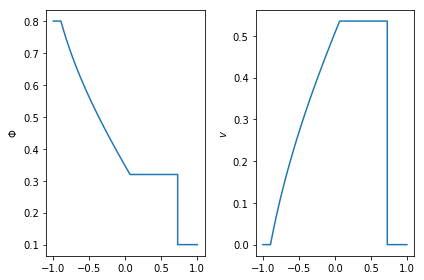

In [32]:
fig, ax = pyplot.subplots(1, 2)
ax[0].plot(lams, phis)
ax[0].set_ylabel(r"$\Phi$")
ax[1].plot(lams, vs)
ax[1].set_ylabel(r"$v$")
fig.tight_layout()

In [33]:
wl = numpy.array([0.80, 0])
wr = numpy.array([0.02, 0])
lams, phis, vs = dam_break(wl, wr)

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


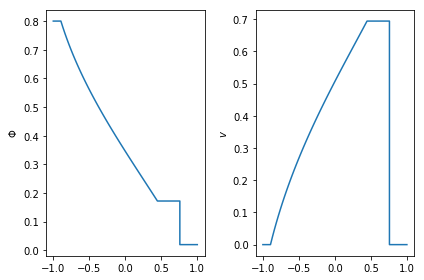

In [34]:
fig, ax = pyplot.subplots(1, 2)
ax[0].plot(lams, phis)
ax[0].set_ylabel(r"$\Phi$")
ax[1].plot(lams, vs)
ax[1].set_ylabel(r"$v$")
fig.tight_layout()

The hard-coded numbers start causing trouble after this.

What are the chances it will work in the "superluminal" regime?

In [35]:
wl = numpy.array([11.0, 0])
wr = numpy.array([1.0, 0])
lams, phis, vs = dam_break(wl, wr, -5, 5)

/Users/ih3/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/ih3/anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:204: RuntimeWarning: Tolerance of 0.00012499999999998623 reached
  warnings.warn(msg, RuntimeWarning)
/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


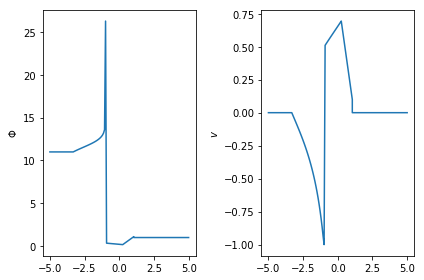

In [36]:
fig, ax = pyplot.subplots(1, 2)
ax[0].plot(lams, phis)
ax[0].set_ylabel(r"$\Phi$")
ax[1].plot(lams, vs)
ax[1].set_ylabel(r"$v$")
fig.tight_layout()

This might be a result of hard-coding the numbers and the particular eigenvalues and vectors, or it may be that this just isn't going to work properly in that regime.

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


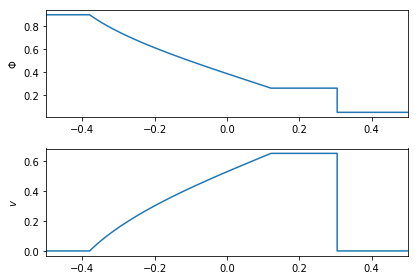

In [38]:
t_end = 0.4
domain = (-0.5, 0.5)
wl = numpy.array([0.90, 0])
wr = numpy.array([0.05, 0])
lams, phis, vs = dam_break(wl, wr, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end)

#numpy.savetxt('sr_swe.txt', numpy.vstack((lams, phis, vs)))

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

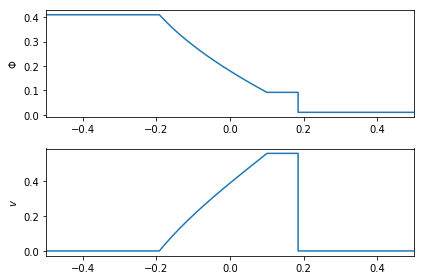

In [99]:
t_end = 0.3
domain = (-0.5, 0.5)
wl = numpy.array([0.41, 0])
wr = numpy.array([0.01, 0])
lams, phis, vs = dam_break(wl, wr, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

# Simplifying

Can we get the rarefaction equation solely in terms of $\Phi$?

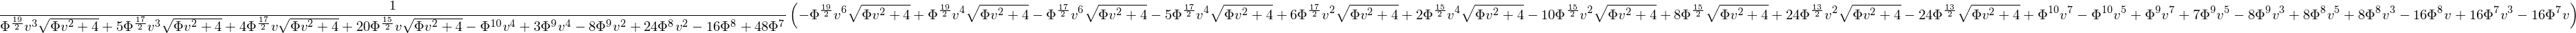

In [38]:
rhs3 = (rhs2[1]/rhs2[0]).expand().simplify()
rhs3

In [49]:
rhs_single_sp = sympy.lambdify((phi, v), rhs3, modules='numpy')
def rhs_single_m(v, phi):
    return rhs_single_sp(phi, v)

In [50]:
rhs_single_m(wl[1], wl[0])

In [78]:
def phi_single_residual(phi_star, wl, wr):
    phi_l = wl[0]
    v_raref = odeint(rhs_single_m, wl[1], [phi_l, phi_star])[-1, 0]
    
    #print(v_raref)
    guess = numpy.array([v_raref, 0.7])
    result = root(shock_residual, guess, args=(phi_star, wr))
    #print('result', result.x)
    w_shock = numpy.array([phi_star, result.x[0]])
    
    return v_raref - w_shock[1]

def shock_residual_single(Vs, phi_star, v_star, w):
    phi, v = w
    W = 1 / numpy.sqrt(1 - v**2)
    W_star = 1 / numpy.sqrt(1 - v_star**2)
    q = numpy.array([phi * W, phi * W**2 * v])
    q_star = numpy.array([phi_star * W_star, phi_star * W_star**2 * v_star])
    f = q * v + numpy.array([0, phi**2 / 2])
    f_star = q_star * v_star + numpy.array([0, phi_star**2 / 2])
    residual = (Vs * (q - q_star) - (f - f_star))[0]
    #print('shock', guess, residual)
    return residual

def dam_break_single(wl, wr, xi_min=-1, xi_max=1):
    assert wl[0] > wr[0]
    # This will probably only work for a very limited range as I've hard-coded limits
    phi_star = brentq(phi_single_residual, 1.1*wr[0], 0.9*wl[0], args=(wl, wr))
    # Left state
    lams = [xi_min]
    phis = [wl[0]]
    vs = [wl[1]]
    # Find rarefaction tail
    lam_l = eval_m(wl)
    lams.append(lam_l)
    phis.append(wl[0])
    vs.append(wl[1])
    # Solve down rarefaction
    phi_raref = numpy.linspace(wl[0], phi_star)
    v_raref = odeint(rhs_single_m, wl[1], phi_raref).flatten()
    #print(v_raref)
    for i, p in enumerate(phi_raref):
        lams.append(eval_m([p, v_raref[i]]))
        phis.append(p)
        vs.append(v_raref[i])
    # Find shock result
    #print(vs)
    v_star = v_raref[-1]
    Vs_guess = 0.8
    Vs = newton(shock_residual_single, Vs_guess, args=(phi_star, v_star, wr))
    lams.append(Vs)
    phis.append(phi_star)
    vs.append(v_star)
    lams.append(Vs)
    phis.append(wr[0])
    vs.append(wr[1])
    #    Right state
    lams.append(xi_max)
    phis.append(wr[0])
    vs.append(wr[1])
    
    return lams, phis, vs

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


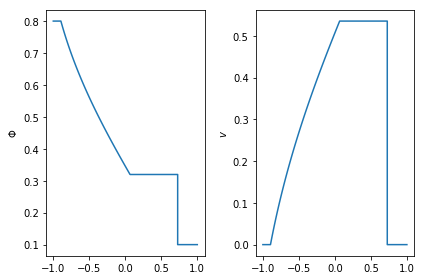

In [65]:
wl = numpy.array([0.80, 0])
wr = numpy.array([0.10, 0])
lams, phis, vs = dam_break_single(wl, wr)

fig, ax = pyplot.subplots(1, 2)
ax[0].plot(lams, phis)
ax[0].set_ylabel(r"$\Phi$")
ax[1].plot(lams, vs)
ax[1].set_ylabel(r"$v$")
fig.tight_layout()

Next one meant to match up with figure 4.3:

/Users/ih3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


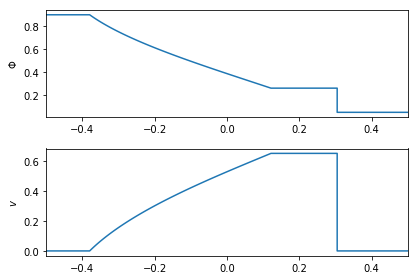

In [79]:
t_end = 0.4
domain = (-0.5, 0.5)
wl = numpy.array([0.90, 0])
wr = numpy.array([0.05, 0])
lams, phis, vs = dam_break_single(wl, wr, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

So the star state looks right, the rarefaction curve looks right, but the shock speed looks wrong.

Test the residual function using shock speed close to the figure:

In [93]:
vs

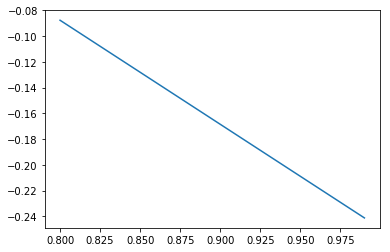

In [94]:
v_star = vs[-3]
phi_star = vs[-3]
Vss = numpy.linspace(0.8, 0.99)
ress = numpy.zeros_like(Vss)
for i, Vs in enumerate(Vss):
    ress[i] = shock_residual_single(Vs, phi_star, v_star, wr)
pyplot.plot(Vss, ress)

So it really isn't finding that shock speed at all.

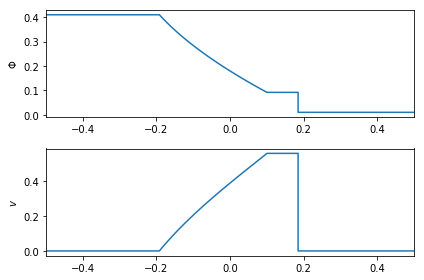

In [96]:
t_end = 0.3
domain = (-0.5, 0.5)
wl = numpy.array([0.41, 0])
wr = numpy.array([0.01, 0])
lams, phis, vs = dam_break_single(wl, wr, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()